In [1]:
from data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from tqdm.notebook import tqdm
from scipy.stats import spearmanr

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)
print(torch.version.cuda)

cuda
12.4


In [2]:
image_size = (224, 224)

train_dataset = Dataset("data/train", size=image_size, save_in_ram=False)
test_dataset = Dataset("data/test", size=image_size, save_in_ram=False)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)

Loading data from data/train


  0%|          | 0/880 [00:00<?, ?it/s]

Data loaded
Loading data from data/test


  0%|          | 0/220 [00:00<?, ?it/s]

Data loaded


In [11]:
# model = torchvision.models.densenet161()
# model.classifier = torch.nn.Linear(2208, 4)
# model.load_state_dict(torch.load("pretrained_on_BEHSOF+_densenet161.pth"))
model = torchvision.models.densenet121()
# model.classifier = torch.nn.Linear(1024, 4)
# model.load_state_dict(torch.load("pretrained_on_BEHSOF+_densenet121.pth"))

# model.classifier = torch.nn.Linear(2208, 1)
model.classifier = torch.nn.Linear(1024, 1)
# model.load_state_dict(torch.load("densenet121_testloss8.7.pth"))
model.load_state_dict(torch.load("densenet121_size224.pth"))
model.to(device)

# loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

epoch = 0
min_test_loss = 1e10
best_model = None

train_losses = []
test_losses = []

In [4]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss = 0
    for x, y in tqdm(dataloader, total=len(dataloader)):
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    train_loss /= len(dataloader)
    return train_loss


def test(dataloader, model, loss_fn, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in tqdm(dataloader, total=len(dataloader)):
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
    test_loss /= len(dataloader)
    return test_loss

In [7]:
epochs = 10
for i in range(epochs):
    print("Epoch:", epoch+1)
    train_loss = train(train_loader, model, loss_fn, optimizer)
    test_loss = test(test_loader, model, loss_fn, epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if test_loss < min_test_loss:
        print("Saving model...")
        min_test_loss = test_loss
        best_model = model.state_dict().copy()
    print("train_loss:", train_loss)
    print("test_loss:", test_loss)
    epoch += 1
print("Done!")

Epoch: 11


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

train_loss: 4.635227697545832
test_loss: 13.531762810186907
Epoch: 12


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

train_loss: 3.717031584273685
test_loss: 15.411274773424323
Epoch: 13


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

train_loss: 3.5995941522446544
test_loss: 13.125659105994485
Epoch: 14


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

train_loss: 2.918561381643469
test_loss: 12.893070381337946
Epoch: 15


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

train_loss: 3.123289118571715
test_loss: 14.270318403027275
Epoch: 16


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

train_loss: 3.161900127204982
test_loss: 13.57318573106419
Epoch: 17


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

train_loss: 2.4207107688892973
test_loss: 15.617203099077399
Epoch: 18


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Saving model...
train_loss: 2.3197091682390734
test_loss: 12.085349820960651
Epoch: 19


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

train_loss: 1.979444255070253
test_loss: 14.9577580798756
Epoch: 20


  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

train_loss: 2.276521590216593
test_loss: 15.856153319098732
Done!


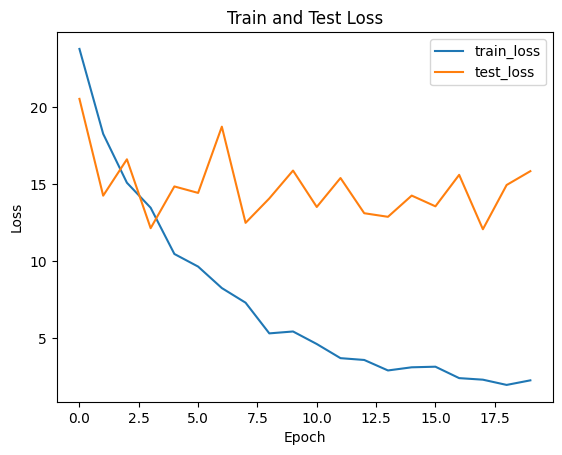

In [8]:
# plot train and test loss
plt.plot(train_losses, label="train_loss")
plt.plot(test_losses, label="test_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train and Test Loss")
plt.show()

In [ ]:
# best_model_path = "densenet121_.pth"
# torch.save(best_model, best_model_path)

In [12]:
test_targets = [i[1].item() for i in test_dataset]

model_outputs = []
for x, y in tqdm(test_dataset):
    with torch.no_grad():
        pred = model(x.unsqueeze(0).to(device))
        model_outputs.append(pred[0][0].item())

spearman = spearmanr(test_targets, model_outputs)
print("Spearman correlation coefficient:", spearman.statistic)
print("Spearman p-value:", spearman.pvalue)

  0%|          | 0/220 [00:00<?, ?it/s]

Spearman correlation coefficient: 0.8236972297791993
Spearman p-value: 1.2636009985500785e-55


In [8]:
# model_outputs

In [9]:
# train_dataset[0][0][0][100]

In [10]:
# Test Lasso
model.classifier = torch.nn.Identity()  # Remove final linear layer

model.eval()
features = []
targets = []
with torch.no_grad():
    for image, label in tqdm(train_loader):
        image = image.to(device)
        out = model(image)  # Shape: [B, 1024]
        features.append(out.cpu().numpy())
        targets.append(label.cpu().numpy())

# Stack arrays
import numpy as np
X = np.vstack(features)                  # Shape: [N, 1024]
y = np.concatenate(targets, axis=0)      # Shape: [N]

  0%|          | 0/220 [00:00<?, ?it/s]

In [11]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = LassoCV(cv=5)
lasso.fit(X_scaled, y)

print("Lasso R² score:", lasso.score(X_scaled, y))

/home/kozak/kpi/diploma/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso R² score: 0.9933992028236389


/home/kozak/kpi/diploma/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.392e+03, tolerance: 6.409e+01
  model = cd_fast.enet_coordinate_descent(


In [12]:
model.eval()
test_features = []
test_targets = []
with torch.no_grad():
    for image, label in tqdm(test_loader):
        image = image.to(device)
        out = model(image)  # Shape: [B, 1024]
        test_features.append(out.cpu().numpy())
        test_targets.append(label.cpu().numpy())

# Stack arrays
import numpy as np
test_X = np.vstack(test_features)                  # Shape: [N, 1024]
test_y = np.concatenate(test_targets, axis=0)      # Shape: [N]

  0%|          | 0/110 [00:00<?, ?it/s]

In [13]:
lasso_pred = lasso.predict(scaler.transform(test_X))
print("Lasso test R² score:", lasso.score(scaler.transform(test_X), test_y))
print("Lasso test Spearman correlation:", spearmanr(test_y, lasso_pred))

Lasso test R² score: 0.7405650615692139
Lasso test Spearman correlation: SignificanceResult(statistic=np.float64(0.8459005925801059), pvalue=np.float64(1.954899603096638e-61))
